# The Project <a class="anchor" id="t1"></a>

A year ago, our team at the fictional company Mad Flow embarked on a new exiting project. Our primary objective was to create a real-time traffic forecasting system by leveraging heterogeneous data from smart-cities. Traffic analysis has become a vital component of smart cities, enabling enhanced road management and governance through improved traffic insights. 

Throughout the project's development, we encountered technical limitations that prevented us from solely relying on Pandas and plain Python. Our solution emerged through PyKX and Kdb+/q, a journey that's detailed in the post [All Roads Lead to Kdb](https://www.habla.dev/blog/2023/07/31/all-roads-lead-to-pykx.html).

In this technical report, we will outline the process of migrating our code to the KX platforms. Before delving into the implementation details, we will first present the use case and the current status of our project. Then, we will talk about the q embedding on Python and vice versa and, since we did the migration twice (once to PyKX and again to pykx.q), the technical details of both implementations. By sharing our experiences with Kdb+/q and PyKX, we hope to shed light on the positive impact these tools have had on our endeavor.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">Original Python Project</a> on Github. 
</div>

This is the **outline** of the report: 
    
[**The project**](#t1)   
  [**The Use Case**](#t11)   
  [**The Data**](#t12)   
  [**The Cleaning**](#t13)   
  [**The Final Table**](#t14)   
  [**The Interpretation**](#t15)   
[**PyKX migration:**](#t2)   
  [**PyKX saving the day!**](#t21)   
  [**Datasets**](#t23)   
  [**Model**](#t24)   
[**pykx.q migration**](#t3)   
[**Final thoughts**](#t4)
    
## The Use Case <a class="anchor" id="t11"></a>
    
In the project's initial phase, our objective was to prepare and ingest the data into an LSTM model. As is usual in projects associated with smart cities, the data is notably heterogeneous, demanding substantial preparatory efforts. Data on weather and traffic in the city of Madrid will be used. 

Although this project is novel in the city of Madrid, there are many articles that support it. For example, [F. Malik et al.](https://www.mdpi.com/1424-8220/20/13/3749) forecasted traffic in Madrid based on air pollution through a model based on LSTM.
   
Regarding the weather and traffic correlation there are numerous studies, with a particular focus on rainfall.While none of these studies are conducted specifically in Madrid, they have been carried out in various major cities like Manchester ([A. Essien et al.](https://pure.manchester.ac.uk/ws/portalfiles/portal/72721911/DEXA_Camera_8_pages.pdf)), Shenzhen ([Y. Yao et al.](https://ieeexplore.ieee.org/document/8964560)), Belgrade ([M. Vidas et al.](https://www.safetylit.org/citations/index.php?fuseaction=citations.viewdetails&citationIds[]=citjournalarticle_716898_14)). The results of these studies anticipate a weekday traffic volume increase of 5-15% during peak hours.
    
We found several blogs in [KX developer](https://kx.com/resources/developer-blog/)  related to the use of PyKX over Pandas, such as [A. Morrison](https://kx.com/blog/accelerating-python-workflows-using-pykx/) where he uses PyKX in the field of financial services. This article shows a big speed advantage of PyKX over Pandas.
    
## The Data <a class="anchor" id="t12"></a>


The [Madrid City Council](https://datos.madrid.es/portal/site/egob) provides weather and traffic data for Madrid, encompassing both real-time and historical records. For model training purposes, only the historical data is required. This data, formatted in CSV, is categorized by months from the year 2018 to the present.

**Weather**

Stations positioned across the city of Madrid capture [weather data](https://datos.madrid.es/egob/catalogo/300352-141-meteorologicos-horarios.csv) (**Click to download**), which is presented in the following table:



|    |   weather_station |   magnitude |   year |   month |   day |    H01 | V01   | ...|
|---:|------------------:|-----------:|-------:|--------:|------:|-------:|------:|:------|
|  0 |               108 |         81 |   2022 |      12 |    22 |  270   | N     | ...|
|  1 |               108 |         82 |   2022 |      12 |    22 |    9   | N     |...|
|  2 |               108 |         83 |   2022 |      12 |    22 |   94.7 | N     |...|
|  3 |               108 |         86 |   2022 |      12 |    22 | 1031   | N     |...|
|  4 |               108 |         87 |   2022 |      12 |    22 |    2   | N     |...|


The documentation informs us that the 'magnitude' column indicates the type of meteorological data recorded in the respective row:

    · 80: ultraviolet
    · 81: wind
    · 82: direction
    · 83: temperature
    · 86: humidity
    · 87: pressure
    · 88: solar
    · 89: rainfall
    
For each hour, there are two columns: the first provides the value for the data type indicated by the 'magnitude' column, along with its validity status. Additionally, there are columns associated with the time at which the measurement is recorded."

there's the identifier of the meteorological station, which can be correlated with its coordinates using another table provided by the Madrid City Council.

Finally, there's the identifier of the meteorological station, which can be correlated with its coordinates using the [weather stations](https://datos.madrid.es/egob/catalogo/300360-1-meteorologicos-estaciones.csv) table provided by the Madrid City Council:

|    |   weather_station |   Longitude |   Latitude |
|---:|------------------:|------------:|-----------:|
|  0 |                 4 |    -3.71226 |    40.4239 |
|  1 |                 8 |    -3.68232 |    40.4216 |
|  2 |                16 |    -3.63924 |    40.44   |
|  3 |                18 |    -3.73184 |    40.3948 |
|  4 |                24 |    -3.74734 |    40.4194 |

**Traffic**

Traffic sensors are located at traffic lights across the city of Madrid. The collected data gathers various measurements of the road conditions, including speed and traffic volume. All of these metrics are encapsulated in the 'load' metric, represented as a percentage that quantifies congestion. The structure of the [traffic table]() is as follows: 
    
Traffic sensors are located at traffic lights in the city of Madrid. The data obtained is made up of several measurements of the road situation such as speed or traffic volume. All of these metrics are coded into the "load" metric (a percentage that measures congestion). The [traffic table](https://datos.madrid.es/egob/catalogo/208627-115-transporte-ptomedida-historico.zip) head is:

|    |   traffic_station | tipo_elem   |   intensidad |   ocupacion |   load |   vmed | error   |   periodo_integracion | date                |
|---:|------------------:|:------------|-------------:|------------:|-------:|-------:|:--------|----------------------:|:--------------------|
|  0 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:00:00 |
|  1 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:15:00 |
|  2 |              1001 | M30         |          300 |           1 |      0 |     66 | N       |                     5 | 2022-12-01 00:30:00 |


The table also contains a column for the date and another that identifies the sensor that will be used to link it with its coordinates using the next [traffic stations table](https://datos.madrid.es/egob/catalogo/202468-170-intensidad-trafico.csv):

|    | "tipo_elem"   |   "distrito" |   "id" | "cod_cent"   | "nombre"                                                          |   "utm_x" |     "utm_y" |   Longitude |   Latitude |
|---:|:--------------|-------------:|-------:|:-------------|:------------------------------------------------------------------|----------:|------------:|------------:|-----------:|
|  0 | "URB"         |            4 |   3840 | "01001"      | "Jose Ortega y Gasset E-O - Pº Castellana-Serrano"                |    441615 | 4.47577e+06 |    -3.68832 |    40.4305 |
|  1 | "URB"         |            4 |   3841 | "01002"      | "Jose Ortega y Gasset O-E - Serrano-Pº Castellana"                |    441706 | 4.47577e+06 |    -3.68726 |    40.4305 |
|  2 | "URB"         |            1 |   3842 | "01003"      | "Pº Recoletos N-S - Almirante-Prim"                               |    441319 | 4.47484e+06 |    -3.69173 |    40.4221 |
    
## The Cleaning  <a class="anchor" id="t13"></a>

After loading the data, the next step was to prepare it for analysis and modeling. Given the heterogeneous nature of the datasets, data cleaning will be performed separately, and the data will be consolidated into a single table at a later stage.

#### Weather

The steps followed to clean the climate table are:

1. In the weather dataset we first have the date separated into day, month and year, but in traffic all these data are together. This is why the columns have been grouped into a date column of shape: ```day-month-year```. 

2. We also transform each hour value measurement and its validity into independent rows and take the opportunity to remove invalid measurements:

|       | hour            |   value |
|------:|:----------------|--------:|
|     0 | 0 days 00:00:00 |    7.1  |
|     1 | 0 days 00:00:00 |    6.8  |
|     2 | 0 days 00:00:00 |    2.8  |
|     3 | 0 days 00:00:00 |    5.6  |

3. To homogenize the time measure with the traffic table we join the date with the time. The new date shape is ```date-month-year hour:minute:second```

4. Finally, we convert the different types of measurement into columns so that it looks more organized:

|      | date                |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |
|-----:|:--------------------|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|
|    0 | 2022-12-01 00:00:00 |                 4 |           0 |          0 |          0 |        0   |       0 |           7.1 |   0    |
|    1 | 2022-12-01 00:00:00 |                 8 |           0 |         67 |          0 |        0   |       0 |           9.4 |   0    |
|    2 | 2022-12-01 00:00:00 |                16 |           0 |         73 |          0 |        0   |       0 |           8.9 |   0    |

#### Traffic

Regarding the traffic table, the steps followed were the following:

1. First we filter out the values with measurement errors. In the documentation they tell us that these values are represented with an "N". 

2. We only keep the load measurement, which is what we are interested in for the analysis.

3. We group the values for each date and station and calculate the average.

The average time for loading and processing a month of traffic information is **43.9 s**. The team was concerned about the slowness and the possible effect it will have on real-time data processing.

**Location**

In order to combine the two previous tables, it's necessary to establish a correspondence between the traffic sensors and the weather stations. This can be achieved by employing a distance matrix and identifying the nearest pairs among the two types of station.  While direct measurement of this distance using coordinates is possible, we opted for the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) which calculates the distance in meters between a pair of coordinates, offering a clearer representation of distances.  This can be observed in the following heatmap, where the distances range from 0 to 20 km:

<figure>
<img src="image_source/heatmap3.png">
<figcaption style = "text-align: center"> <b>Figure 1:</b> Heatmap of distances in km between weather and traffic stations </figcaption>
</figure>
    
## The Final Table <a class="anchor" id="t14"></a>

After preparing the three tables - weather, traffic, and distance - we merge them. Since the weather table has time intervals of 1 hour, whereas the traffic data is in 15-minute intervals, we will combine these tables using an 'asof' join. Ultimately, we can incorporate time and day-of-the-week information to analyze its relationship with traffic congestion.

|    | date                |   traffic_station |   load |   Distance |   Closest |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |   weekday |   hour |
|---:|:--------------------|------------------:|-------:|-----------:|----------:|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|----------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |         14 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |         14 |         0 |                 4 |           0 |          0 |          0 |          0 |       0 |           7.1 |      0 |         3 |      0 |
    
    
## Data interpretation <a class="anchor" id="t15"></a>

Traffic is highly time-dependent. The data will be filtered to extract the peak moments where traffic typically is heavier. This will enhance our understanding of the data. Weekdays tend to have more traffic than holidays, just as daytime have higher traffic flow than nighttime. In the following figure underscores the evident seasonality within the dataset:

<table>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loadperhour.png">
<figcaption style = "text-align: center">   <b>Figure 2:</b> Load per Hour </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/loadperweekday.png">
<figcaption style = "text-align: center">   <b>Figure 3:</b> Load per Weekday </figcaption>
</figure>
            </td>
    </tr>
</table>

Regarding the Rainfall-Load dependency we started seeing that rainy days are very few on our dataset:

|       |       rainfall |
|:------|---------------:|
| count | 841068         |
| mean  |      0.0130932 |
| std   |      0.194232  |
| min   |      0         |
| 50%   |      0         |
| 90%   |      0         |
| 99.9% |      2.9       |
| max   |     10.9       |

Examining the percentiles of the precipitation column, it becomes evident that there are very few recordings with rain. To address this, measurements were categorized into distinct classes based on the intensity of rain. Consequently, a separate analysis was conducted for data involving heavy rain, moderate to light rain, and no rain. The analysis was done hourly to mitigate the temporal dependence of traffic. The average increase in traffic congestion hours due to rain ranges from 5% to 14%%, consistent with the studies presented in [the Use Case](#t12) chapter.

<figure>
<img src="image_source/rainfall.png">
<figcaption style = "text-align: center"> <b>Figure 4:</b> The average traffic load per hour for the measurements with heavy rain (blue), moderate rain (brown) and no rain (green).</figcaption>
</figure>

To verify that these differences between groups are significant, we can perform an anova test. And we see that in all hours there is great evidence that the load is different between the different levels of rain. For example, for hour 12:

|             |          sum_sq |    df |        F |       PR(>F) |
|:------------|----------------:|------:|---------:|-------------:|
| C(rainfall) | 37650.7         |     6 |  20.1144 |   1.3346e-23 |
| Residual    |     8.01363e+06 | 25687 | nan      | nan          |

It was decided to include rainfall within the model. The rest of the meteorological conditions did not give such a clear result, so they were left out.

## The Model <a class="anchor" id="t16"></a>

To assess performance, we created a toy model using a simple LSTM with 5-step memory to predict the load at a specific traffic station. The input includes the precedings data of the load, the rainfall, the hour and day of the week. The results for a single station seem quite positive as can be seen in [Graph 6](#Image61). However, the computational expenses for an individual station and a single month data is unaffordable for the project budget. Furthermore, the preprocessing demands an excessive amount of time, rendering it impractical for real-time application.

<table> <a class="anchor" id="Image61"></a>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loss_graph_p.png">
<figcaption style = "text-align: center">   <b>Figure 5:</b> Train vs Test loss plot  </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/fc_p.png">
<figcaption style = "text-align: center">   <b>Figure 6:</b> Traffic Forecasting for a traffic station </figcaption>
</figure>
            </td>
    </tr>
</table>


# PyKX migration <a class="anchor" id="t2"></a>

Now that we have cleared out the project's goal, we will explain the steps that have been taken for the code migration, which include a training stage in q and pykx for the team, the datasets loading and cleaning and the model ingestion. But first of all we need to install and import PyKx:

In [1]:
!pip install pykx

In [1]:
import pykx as kx

<div class="alert alert-block alert-info">
<b> 🔍 A license is required to use some of the following features. You can find more information in <a href="https://code.kx.com/pykx/1.6/getting-started/installing.html">
            PyKX installation documentation</a>. 
</div>

## Learning PyKX <a class="anchor" id="t21"></a>

Before starting the project, the Mad Flow team received training from [Habla Computing](https://hablapps.com/) on q and PyKX. After this introduction to KX platforms, some of the developers fell in love with q, while others felt more comfortable in the Python ecosystem. PyKX is designed so that these two profiles coexist in the same development environment. The team has compiled perspectives on programming with PyKX along with various techniques they discovered during training:

* **[Useful Read/Write Functions](https://code.kx.com/pykx/1.6/api/read.html)**

>*"PyKX offers several functions that help loading and writing data, they are very versatile and the parameters are very intuitive."* - Félix Functor

In [2]:
traffic_station = kx.q.read.csv('../pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

In [3]:
traffic_station[:3].pd()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud
0,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
1,URB,4,3841,b'01002',b'Jose Ortega y Gasset O-E - Serrano-P\xc2\xba...,441705.882340,4.475770e+06,-3.687256,40.430524
2,URB,1,3842,b'01003',b'P\xc2\xba Recoletos N-S - Almirante-Prim',441319.371258,4.474841e+06,-3.691727,40.422132


* **[Use pythonic indexing](https://code.kx.com/pykx/1.6/user-guide/fundamentals/indexing.html)**

> *"Accessing data from q objects such as lists or tables from python can be done with indexing similar to what you can use in numpy or pandas. This has made my job much easier."* - Jesús Lambda

In [4]:
elem = traffic_station["tipo_elem"]
lat = traffic_station["latitud"]
print(lat[:5])

40.4305 40.43052 40.42213 40.42143 40.43378


* **[Use q functions]()**

> *"For those like me who want to delve into the q language and gain experience, you can use language functions, ...*

In [5]:
distinct = kx.q("distinct", elem) # unique values in the list
print(distinct) 

`URB`other`M30


> *... iterate over them ...*

In [6]:
print(kx.q("lower").each(distinct)) # lower case unique values of the list

`urb`other`m30


>*... or even create and use them with pykx objects."* - Eloy Projection

In [7]:
print(kx.q("{u !(sum x=) each u:distinct x}", elem)) # Count the occurrences of distinct values

URB  | 4266
other| 128
M30  | 296


* **Use [Numpy](https://code.kx.com/pykx/1.6/user-guide/advanced/numpy.html) and  [Pandas](https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html)**

> *"Those of us who are not yet so familiar with the ecosystem that we can continue using part of the functionality of Numpy (universal functions)...*

In [10]:
import numpy as np

def numpy_mean(arr):
    return np.add.reduce(arr) / len(lat)

print(numpy_mean(lat))

40.42871


>*... and from pandas via the Pandas API."* - Emma Doric

In [18]:
import os
os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
import pykx as kx
import numpy as np
import pandas as pd

traffic_station[traffic_station["tipo_elem"]=="other"][:5].pd() # filter rows where the values of a column meet a condition

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud
0,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
1,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
2,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
3,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
4,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502


<div class="alert alert-block alert-info">
<b>To use it we only have to import numpy and pandas and activate a flag. Pandas API is still in the development phase, so it does not have all the functions of Pandas yet. More information in <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html"> Pandas API </a> . 
</div>

* **Use [qSQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

> *"SQL queries are very powerful and concise at the same time. PyKX allows you to query PyKX objects as well as API functions...* 

In [19]:
print(kx.q.qsql.select(traffic_station, {"name":"5 # nombre"}, where="tipo_elem = `other")) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


> *...or using our own functions q."*

In [20]:
print(kx.q("{select name:5#nombre from x where tipo_elem = `other}", traffic_station)) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


* **Use [SQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

>*"Whoa! PyKx lets you use SQL queries too!"*

In [21]:
print(kx.q.sql("select nombre as name from $1 where tipo_elem='other' limit 5", traffic_station))

QError: .s.sp

* **Q Context**

> *"I'm more comfortable programming in q, so I work in the q context. PYKX objects can be passed into the q context and work with them as if you were in a q ecosystem:"*

In [15]:
kx.q["traffic_station"] = traffic_station # Move Pykx Object to Q Context

print(kx.q("select name:5#nombre from traffic_station where tipo_elem = `other")) # Working with the table inside q

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


* **Python/Q Transform**

> *"I'm new to the project and still have to catch up with q. In the meantime I can pass the objects from q to pandas...*

In [16]:
traffic_station.pd().head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud
0,URB,4,3840,b'01001',b'Jose Ortega y Gasset E-O - P\xc2\xba Castell...,441615.343347,4.475768e+06,-3.688323,40.430502
1,URB,4,3841,b'01002',b'Jose Ortega y Gasset O-E - Serrano-P\xc2\xba...,441705.882340,4.475770e+06,-3.687256,40.430524
2,URB,1,3842,b'01003',b'P\xc2\xba Recoletos N-S - Almirante-Prim',441319.371258,4.474841e+06,-3.691727,40.422132
3,URB,4,3843,b'01004',b'P\xc2\xba Recoletos S-N - Pl. Cibeles- Recol...,441301.632986,4.474764e+06,-3.691929,40.421433
4,URB,4,3844,b'01005',b'(AFOROS) P\xc2\xba Castellana S-N - Eduardo...,441605.765072,4.476132e+06,-3.688470,40.433782


>*... numpy, ...*

In [17]:
lat.np()[:5]

array([40.43050187, 40.43052394, 40.42213209, 40.42143334, 40.43378206])

> *... and python to work on ...*

In [18]:
lat.py()[:5]

[40.4305018691825,
 40.4305239406404,
 40.4221320929972,
 40.4214333442836,
 40.4337820578943]

>*... and then back to q so that colleagues can continue the work with PyKX objects."*

In [19]:
kx.toq(lat.py())

pykx.FloatVector(pykx.q('40.4305 40.43052 40.42213 40.42143 40.43378 40.42351 40.42816 40.42879 40.426..'))

During the development of the project some of these methods will be described in depth. The best thing is that they are fully compatible with each other, so developers can choose the one that is most comfortable for them!

## Datasets <a class="anchor" id="t22"></a>

### Weather

The loading of the data will be done with the utility provided by [PyKX](https://code.kx.com/pykx/1.4/api/read.html):

In [22]:
weather = kx.q.read.csv('../dic_meteo22.csv', types='I'*4 + '*'*4 + 'FS'*24, delimiter=';')

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;">
    <div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
    <i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;NEW FEATURE: <a href="https://code.kx.com/pykx/1.6/api/read.html">PyKX Read/Write Utils </a>
    </div>
    <div style="background-color: #e5ffdf70;  padding: 20px;">
    <p style="color: black;padding: 15px; border-radius: 5px;text-align: right;margin-right: 10%;font-size: 115%;"> "PyKX offers several functions that help loading and writing data, they are very versatile and the parameters are very intuitive." </p>
    <footer style="text-align: right;margin-right: 5%;font-size: 105%;"> —Félix Functor </footer>
<div>
</div>
</div>
</div>

<div class="alert alert-block alert-info" style="background-color: #e9f6fc9c; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00abff;">
    <div class="alert-header custom-card-header" style="background-color: #b9e8ff70;color: black; padding: 10px; font-size: 115%;">
    <i class="fa fa-commenting" aria-hidden="true" style="color:#00abff"></i>&nbsp;&nbsp;&nbsp; NEW FEATURE: <a href="https://code.kx.com/pykx/1.6/api/read.html">PyKX Read/Write Utils </a>
    </div>
    <div style="background-color: #e9f6fc9c;  padding: 20px;">
    <p style="color: black;padding: 15px; border-radius: 5px;text-align: right;margin-right: 10%;font-size: 115%;"> "PyKX offers several functions that help loading and writing data, they are very versatile and the parameters are very intuitive." </p>
    <footer style="text-align: right;margin-right: 5%;font-size: 105%;"> —Félix Functor </footer>
<div>
</div>
</div>
</div>

The parameters of this function are quite standard. The url to the file and the delimiter are indicated. We highlight the *types* parameter that expects the q [types](https://code.kx.com/q/basics/datatypes/) of each column. Our table is now a PyKX object:

In [23]:
type(weather)

pykx.wrappers.Table

VER LA TABLA CON PYKX -> Acceso a datos de manera pythonica
VER LA TABLA CON PANDAS -> Pasar de q object a python object

But it is not in the q context. Let's see how to access these objects and how to use q features on them. Let's start with the simple *xcol* function, which allows us to rename columns:

In [24]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)

We see that this function is overloaded in PyKX. Many q functions are available through the `pykx.q` interface. The attributes are identical to those expected in the q function but with Python structures. These functions are compiled and perfectly explained in the [PyKX documentation](https://code.kx.com/pykx/1.6/api/q/q.html). 

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;">
    <div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
    <i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;NEW FEATURE: <a href="https://code.kx.com/pykx/1.6/api/read.html">Use q functions </a>
    </div>
    <div style="background-color: #e5ffdf70;  padding: 20px;">
    <p style="color: black;padding: 15px; border-radius: 5px;text-align: right;margin-right: 10%;font-size: 115%;"> "For those, like me who want to dig deeper into kdb+/q and gain experience, you can use q functions, ... </p>
        <div style="background-color: #eee;border: 1px solid #999;display: block;padding: 20px;margin-left: 10%;margin-right: 10%; color:black"> >>> kx.q("distinct", ['A', 'B', 'B', 'B' ,'C']) 
       <br> ... `A`B`C </div><br>
        <p style="color: black;padding: 15px; border-radius: 5px;text-align: right;margin-right: 10%;font-size: 115%;"> ... iterate over them ... </p>
            <div style="background-color: #eee;border: 1px solid #999;display: block;padding: 20px;margin-left: 10%;margin-right: 10%; color:black"> >>> kx.q("lower").each(['A', 'B', 'C'])
       <br> ... `a`b`c </div><br>   
        <p style="color: black;padding: 15px; border-radius: 5px;text-align: right;margin-right: 10%;font-size: 115%;"> ... or even create and use them with pykx objects."</p>
         <div style="background-color: #eee;border: 1px solid #999;display: block;padding: 20px;margin-left: 10%;margin-right: 10%;color:black"> >>> kx.q("{u !(sum x=) each u:distinct x}", ['A', 'B', 'B', 'B' ,'C'])
       <br> ... A| 1<br>... B| 3<br>... C| 1 </div><br>   
    <footer style="text-align: right;margin-right: 5%;font-size: 105%;"> —Félix Functor </footer>
</div>
</div>
</div>


Apart from this functions we have the `kx.q.qsql` interface, which allows us to query into tables. Specifically we used `select`, `update` and `delete`, which share some common characteristics, mainly with the arguments they receive.

Both `select` and `update` share roughly this function call structure:

`kx.q.sql.{function}({tab}, columns=..., where=..., by=...)`

The `columns` argument expects either a list of strings or a dictionary where the key is the column name and the value is the actual value you want in this column if let's say you want to apply a function to it. Let's look at this specific example:

In [25]:
weather = kx.q.qsql.delete(weather, ['PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

With the above code we have removed several columns that are not relevant to the analysis.

The next task we need to do is combine the year, month, and day into a single date column. To do this, we started by accessing these three columns. This can be done by indexing:

In [26]:
print(weather["year", "month", "day"])

"2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" ..
"12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   ..
"22"   "22"   "22"   "22"   "22"   "22"   "22"   "01"   "02"   "03"   "04"   ..


We see that the result is three lists of the sample size. Our goal is a list of sample size with the three elements that make up the date joined together:

In [27]:
print(kx.q.flip(weather["year", "month", "day"])[:3])

"2022" "12" "22"
"2022" "12" "22"
"2022" "12" "22"


Looks like we're getting close now we have a sample size list with a list in each position containing 3 elements: the day, the month and the year. To join each set of the list into a single joined element, the *each* iterator will be used:

In [28]:
print(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))[:3])

"20221222"
"20221222"
"20221222"


All that remains is to convert the data type from string to date. Unfortunately, some functions (especially the overloaded glyphs) are not yet implemented. For example cast (`$`), take (`#`), concat (`,`)... So we are forced to abandon pythonic way of calling q functions and perform this casting writing kdb+/q code using the pykx.q method:

In [29]:
date = kx.q('"D"$',(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))))
print(date[:3])

2022.12.22 2022.12.22 2022.12.22


Finally, we add this column to our table:

In [30]:
weather_ = kx.q.qsql.update(weather, columns = {'date': date})

Some team members started using kdb/q code instead of PyKX functions in the pythonic way, they found the code more elegant and concise. Once the team had a little more fluency, a function entirely in q was proposed:

In [31]:
weather = kx.q.qsql.update(weather, columns = {'date':'"D"$ raze each flip(year;month;day)'})

Again, both solutions are fully compatible, even combinable, it is up to the programmer to use one or the other methodology. 

The three columns that are already included in date can now be removed:

In [32]:
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day'])

The current state of the weather table is as follows:

In [33]:
weather[:3].pd()

,weather_station,magnitude,H01,V01,H02,V02,H03,V03,H04,V04,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,date
0,108,81,270.0,N,252.0,N,216.0,N,242.0,N,...,V,228.0,V,227.83,V,213.67,V,233.83,V,2022-12-22
1,108,82,9.0,N,8.0,N,9.0,N,8.0,N,...,V,10.0,V,9.00,V,9.00,V,8.00,V,2022-12-22
2,108,83,94.7,N,97.6,N,96.6,N,97.5,N,...,V,91.4,V,93.80,V,96.30,V,98.70,V,2022-12-22


Now it's time to turn our attention into breaking down the H* and V* queries into multiple rows, and supplying a time column to avoid missing information. The way to proceed in q would be to use functional qsql to select the columns that follow the previous patterns, but we are going to take advantage of the fact that the q code in pykx is introduced through Strings to avoid it:

In [34]:
def functionalSearch(cols, pattern, func):
  xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
  xstring = func.format(kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8"))
  return xcols, xstring

The above function receives a list of columns, a pattern to search for, and a function q in string format that passes as an argument the columns found following that pattern in qSQL format (where columns are accessed with their names and not with a symbol). Applying this to all columns starting with *"H"* returns these columns as a vector of Symbols and in a String these columns in qSQL format:

In [35]:
cols = kx.q.cols(weather)
found_columns, qsql_function = functionalSearch(cols, b'H*', "{}")

print("Columns found: ", found_columns)
print("qSQL function: ", qsql_function)

Columns found:  `H01`H02`H03`H04`H05`H06`H07`H08`H09`H10`H11`H12`H13`H14`H15`H16`H17`H18`H19`..
qSQL function:  H01;H02;H03;H04;H05;H06;H07;H08;H09;H10;H11;H12;H13;H14;H15;H16;H17;H18;H19;H20;H21;H22;H23;H24


This is very powerful, as it allows us to use qSQL with variables without having to use functional forms (usually complicated for first-time kdb/q developers).


<div class="alert alert-block alert-info">
<b> Although for reasons of the post we try to stay as long as possible in pykx, the use of python entirely to form these queries in string format avoids encoding transformations.
</div>


Let's use the above for the columns beginning **H**, which will give us the measurement value; and the columns that begin with **V**, which tell us if the measurement is valid. The function that we must use so that the measurements in column format become rows is *flip*:

In [36]:
hcols, value = functionalSearch(cols, b'H*', "flip({})")
vcols, valid = functionalSearch(cols, b'V*', "flip({})")

Now we just have to pass our built-in functions in String format to the qSQL "update" function, together with the 24 hours repeated the initial number of rows:

In [38]:
weather = kx.q.qsql.update(weather, columns = {'hour': 'count[i]#enlist 01:00*til 24', 'values': value, 'valid': valid})

Columns starting with **H** or **V** can be removed by using the trick again to prevent functional qSQL:

In [39]:
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py())

Let's see the result:

In [40]:
weather[:3].pd()

,weather_station,magnitude,date,hour,values,valid
0,108,81,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[270.0, 252.0, 216.0, 242.0, 239.0, 246.0, 233...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
1,108,82,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
2,108,83,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[94.7, 97.6, 96.6, 97.5, 97.5, 98.2, 98.8, 98....","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."


Now all we have to do is expand the table so that each element of the lists corresponds to a row:

In [41]:
weather = kx.q.ungroup(weather)

You can shrink the table a bit more by removing the rows that are not valid and joining the date with the time:

In [42]:
weather = kx.q.qsql.select(weather, where = 'valid=`V')
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = ["valid", "hour"])
weather[:3].pd()

,weather_station,magnitude,date,values
0,108,81,2022-12-22 10:00:00,263.00
1,108,81,2022-12-22 11:00:00,247.83
2,108,81,2022-12-22 12:00:00,215.83


The **magnitude** column is required to give semantics to the **value**. As established by the dataset creators, the different magnitudes correspond to the items that we collect in the following dictionary:

In [43]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

We just have to change the key by the value of the dictionary. Note that in the following functions an object from the Python world is being passed to a kdb/q function. If Python objects have a direct translation in q, such as dictionaries, they can be passed as attributes in pykx functions. Underneath, pykx takes care of accommodating it to q.

In [44]:
weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)

Finally, all you have to do is separate the different weather conditions into different columns:

In [45]:
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}',magnitude,weather)

The query exec allows us to convert a dictionary stored in a column into multiple columns with the key as the column name and the values as the data in that column. This is useful when we create a dictionary made up of the weather conditions of each row associated with their values. By applying it and grouping we have the weather conditions in different columns for each weather entry and weather station.

### Traffic

This second table will also be loaded into the Python environment:

In [46]:
traffic = kx.q.read.csv('../12-2022.csv', types="IPSIIIISI", delimiter=';')

We are interested in knowing the average load by date and by season, removing measurement errors. The power of qSQL allows us to do this in a single query:

In [47]:
traffic = kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"date":'fecha', "traffic_station": 'id'}, 
                         where = "error=`N")

### Location

Both traffic and weather station tables will be loaded into the environment of q:

In [48]:
kx.q["weather_station"] = kx.q.read.csv('../Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True)
kx.q["traffic_station"] = kx.q.read.csv('../pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

We can now access these objects in kdb/q functions without needing to pass them as pykx or python objects. For example, let's change the name of the columns in both tables so that they have more standard ones:

In [49]:
kx.q("weather_station:(`CODIGO_CORTO`LONGITUD`LATITUD!`weather_station`longitude`latitude)xcol weather_station")
_=kx.q("traffic_station:(`id`longitud`latitud!`traffic_station`longitude`latitude)xcol traffic_station")

To bring them to the Python environment, you just have to return them using q code:

```python
kx.q("table")
```

Our goal is to join these two tables. There seems to be no identifier that allows us to do a standard join. However, both are located by coordinates. We can use the distance between the stations for measuring traffic and weather to join them. To calculate the distance between two coordinates, the Harvesine distance can be used. This distance is already developed in Python but it is not available on q.

One option would be to reimplement it in q, but this is not feasible for some complex libraries. Although slower, there is the alternative of passing our q objects to Python and working with them. However, it is advisable to keep using q objects for as long as possible. These features we just explained for moving from Python objects to q and vice versa allow us, at least temporarily, to reuse Python code. It is also reasonable for the size of tables we are working with in this step. To introduce our q objects in this function, we can use some of the PyKX features to transform them into Python objects that we talked about in [Learning Pykx]().

In [50]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude # weather_station').pd(), 
                             kx.q('`longitude`latitude # traffic_station').pd(),
                             Unit.KILOMETERS, comb=True))

We now have a matrix that measures the distance in kilometers for each pair of traffic and weather stations. We can select the pairs of station identifiers whose minimum distance:

In [51]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('{traffic_station ^ weather_station[x]}' ,  ids)
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

### Final Table

The join of the three tables is fairly straightforward. The one of distances can be joined with any of the two by means of a simple left join. The traffic and weather ones have to be joined with asof join as they have different time intervals. Finally, two columns are added to convey the seasonality of the data to the model: time and day of the week.

In [67]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.toq(['weather_station', 'date']), complete, weather)
complete = kx.q.qsql.update(kx.q("0^",complete),  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

Let's look at this last table:

In [68]:
kx.q("5#",complete).pd()

traffic_load  weather_station  ultraviolet  wind  \
date       traffic_station                                                     
2022-12-01 1001                      0.0               24          0.0  0.54   
           1002                      0.0               24          0.0  0.54   
           1003                      0.0               24          0.0  0.54   
           1006                      0.0               24          0.0  0.54   
           1009                      0.0              110          0.0  0.00   

                            direction  temperature  humidity  pressure  solar  \
date       traffic_station                                                      
2022-12-01 1001                 239.0          6.0      84.0     946.0    1.0   
           1002                 239.0          6.0      84.0     946.0    1.0   
           1003                 239.0          6.0      84.0     946.0    1.0   
           1006                 239.0          6.0      84.0     946.0    1.0   
           1009                   0.0          0.0       0.0       0.0    0.0   

                            rainfall  hour  weekday  
date       traffic_station                           
2022-12-01 1001                  0.0     0        5  
           1002                  0.0     0        5  
           1003                  0.0     0        5  
           1006                  0.0     0        5  
           1009                  0.0     0        5

## Model <a class="anchor" id="t23"></a>

___
A ver si Oscar lo consigue:
```python
import pykx as kx

utils = '''
    \d .utils
    minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}
'''

utils_file = os.environ["QHOME"] + '/utils.q'
with open(utils_file, 'w') as f:
    f.write(utils)
    
kx.q.utils.minMaxScale([1,2,3,4,5,6,7,8,9,10])
```
Oscar sigue en ello (no prometo nada)
___

For model ingestion, we opt for the selection of the necessary columns. Additionally, we normalize the rainfall column using a simple MinMax scaler. This function can be included within the q environment for whenever it's required.

In [69]:
kx.q("minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}")
                  
final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "traffic_load%100", 
                                              "temperature":"minMaxScale temperature", 
                                              "rainfall":"minMaxScale rainfall"}
                                    )

During PyKX migration from Pandas, the main hassle was to migrate the time_window function, as it relied on loops. The way we approached it was to first understand the input we had, the output we needed and then think of an idiomatic way to implement it using q instead of doing a 1:1 migration, which would have probably be more costly in terms of time. In this case, our input was a table and our output was a list of matrices for each station. We created several functions that helped us during the process:

* **sliding window**: given a matrix, x, divides it into chunks of length y:

In [70]:
_=kx.q("""sw:{({y#z _x}[x;y;]')til count b:y _x}""")

* **get target**: For a given matrix, x, it takes the target located in the column z and the first lines are eliminated to match with the chunks length y:

In [71]:
_=kx.q("""gt:{y _(flip x)[z]}""") # gets target (in position z)

* **to Matrix**: Transform the table x to a matrix:

In [72]:
_=kx.q("""toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x}""") # / table to matrix

* **prepareData**: Create the train and test datasets. Select the model needed columns *columns* from the table grouped by traffic station. For each traffic station it lefts *ntest* rows for test. It divide the data with chunks of length *chunkLen*. Finally it create a list of dictionaries for training data and training target (the load column) and test data target.
    
    First off, regardless of whether we needed the train or test output, we needed to get either the last *ntest* records or up to the last *ntest* records. Since we needed to repeat this operation for the given columns, we decided that a functional statement would be the best fit.

    Once we shaped the data the way we needed, it was time to build the list of matrices. This needed to be done using a sliding window but, in order to return a list of matrices (not a list of tables), we used the **toMatrix** function to transform a table to a matrix and **sw** (sliding window) function to apply the sliding window based on a single huge matrix.

    As for the y data, we used the function **gt** (get target) that returned the target (traffic load) as a list with the first *chunkLen*+1 entries removed:

In [73]:
_=kx.q("""
        prepareData:{[data; ntest; chunkLen; columns; locTarget]  
            train:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;_;ntest]')columns]; 
            test:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;#;ntest]')columns];                                                                               
            (((sw[;chunkLen]')test;(gt[;chunkLen;locTarget]')test);((sw[;chunkLen]')train;(gt[;chunkLen;locTarget]')train))   
        }
    """)

Lets test this function with only one station:

In [88]:
station_id = 4010

station = kx.q.qsql.select(final, where=["traffic_station="+str(station_id)])

data = kx.q("prepareData", station, 500, 5, kx.SymbolVector(['rainfall', 'traffic_load', 'hour', 'weekday']), 1)

X_train, y_train = np.array(data[0][0][station_id].py()), np.array(data[0][1][station_id].py())
X_test, y_test =  np.array(data[1][0][station_id].py()), np.array(data[1][1][station_id].py())

And now we will try this datasets with a simple LSTM model:

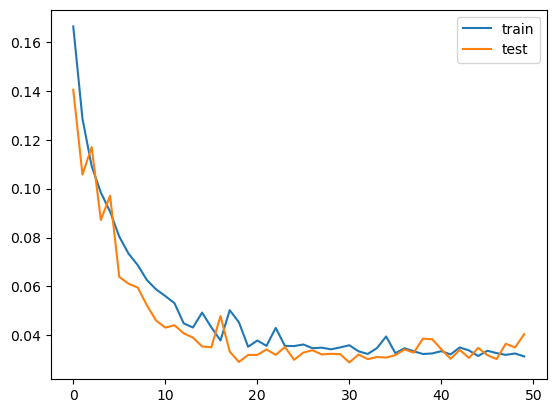

In [94]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import matplotlib.pyplot as plt


model = Sequential()

model.add(LSTM(units = 50, return_sequences=False, input_shape=[None,4]))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=8, 
                    validation_data=(X_test, y_test), 
                    verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

We can see the performance of the model in the following graph:

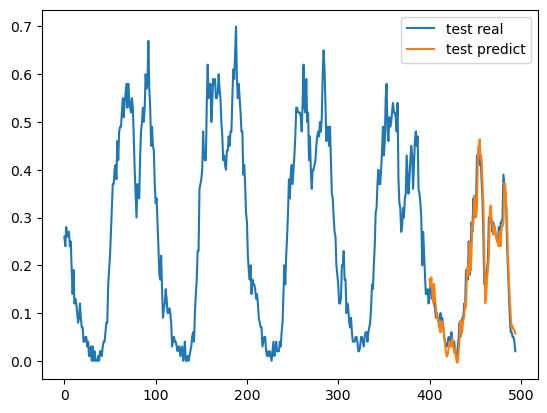

In [95]:
plt.plot(y_test, label='test real')
plt.plot(range(400,495), model.predict(X_test[400:], verbose=0).flatten(), label='test predict')
plt.legend()
plt.show()

# PyKX.q Migration <a class="anchor" id="t3"></a>

When the team got comfortable with the kdb/q language they started using almost entirely q code through `kx.q`, as it was more concise. But the programming became somewhat tedious having to use Strings. This is why it was decided to jump to a q environment. But as seen in the previous chapter, there was Python code that the team couldn't port to q. For this reason it was decided to stay in pykx but this time in the q environment.

pykx.q allows Python code execution on a q environment and, as a result, it opens up the door for new opportunities when dealing with existing codebases as it allows for importing and using Python libraries, both installed on the system and available as .py files.

In our case we use both of these options. We will focus in this post on these opportunities to use Python code in pykx.q and leave the link to the project's [q script]() for the interested reader.

First, we want to execute the `haversine_vector` function to measure the distance between coordinates. Since it's not available on q, we decided to use pykx.q to incorporate this library straight into our q code with these lines:

```q
.pykx.pyexec"from haversine import haversine_vector, Unit";
```

This function expects two Pandas DataFrames as input, so we need to change the default conversion type from "np" or Numpy to "pd" or Pandas:

```q
.pykx.setdefault"pd";
```

Having done this, we can "move" our input variables to the Python memory space using `.pykx.set`

```q
.pykx.set[`a;`longitude`latitude#a];
.pykx.set[`b;`longitude`latitude#b];
```

And finally execute our function

```q
(.pykx.eval"haversine_vector(a, b, Unit.KILOMETERS, comb=True)")`
```

Notice the backtick at the end, this is for converting back to a q type.



The other way we can run Python code is to load a .py (renamed to .p) file using `\l`. This could be done as follows:

```q
system"l kerasmodel.p";
```

Here we have defined two functions named `fit` and `predict`. We can load them and use them like this:

```q
modelfit:.pykx.get`fit;
modelfit[train[0][3403];train[1][3403];test[0][3403];test[1][3403]];
modelpredict:.pykx.get`predict;
res:modelpredict[train[0][3403]];
```

# Final thoughts <a class="anchor" id="t4"></a>

Ultimately, the project was a resounding success. We succeeded in transforming a code characterized by disorganization and performance issues into a concise and competitive solution, empowered by Kdb+/q.
PyKX has facilitated collaboration among a diverse team with varying levels of experience in Kdb+/q. This is thanks to the different levels of integration that PyKX has and their compatibility with each other. It has also provided a user-friendly introduction to Kdb+/q for less experienced team members. Moreover, the code was once again migrated, this time from the 'q' side to PyKX.

The pykx.q library allows, as we have discussed earlier, to use existing Python codebases. This feature is really useful, specially when dealing with code migrations from Python. In our experience, we found specially tough to match the Python input shape to the one converted from q. After converting to Python with .pykx.set we often had to mess around with this transformed objects inside the Python environment or change the default conversion type to match it with the expected input the Python function needed. Once that was dealt with, the experience using this library was really nice and technically impressive.

Since the data we needed to transfer back and forth between memory spaces was not that big (we were cautious this was the case) we didn't notice a performance loss at all. Instead, we achieved a significant improvement compared to Pandas.

Overall we would rate both PyKX libraries highly since it enables users to reuse existing code, reducing the time needed to perform a migration from and to these two languages.